# BMI 707 Project: Comparison to Non-deep Learning Approaches

Establish Baseline

In [3]:
!pip install torch_geometric
!pip install biopython
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.1 MB/s eta 0:00:00


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import requests
import networkx as nx
from scipy.spatial.distance import euclidean
from Bio.PDB import PDBParser, PDBList
from torch_geometric.nn import GCNConv, GraphNorm, global_mean_pool

from google.colab import drive
drive.mount('/content/drive')

from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

Mounted at /content/drive


In [5]:
class DeltaDDGDataset(Dataset):
    def __init__(self, all_results):
        self.all_results = all_results

    def __len__(self):
        return len(self.all_results)

    def __getitem__(self, idx):
        return self.all_results[idx]

    def save(self, path):
        data = {
            'all_results': self.all_results,
        }
        torch.save(data, path)

    @classmethod
    def load(cls, path):
        data = torch.load(path, weights_only=False)
        obj = cls.__new__(cls)
        obj.all_results = data['all_results']
        return obj

In [6]:
#load the data from saved files

# train_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_train_set.pkl")
# val_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_val_set.pkl")

train_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/train_dataset_yuh.pkl")
val_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/val_dataset_yuh.pkl")#, weights_only=False)
test_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/test_dataset_yuh.pkl")#, weights_only=False)

#convert to dataloader object for training

train_loader_official = DataLoader(train_dataset_loaded, batch_size=16, shuffle=True)
val_loader_official = DataLoader(val_dataset_loaded, batch_size=16)
test_loader_official = DataLoader(test_dataset_loaded, batch_size=16)


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
next(iter(train_loader_official))

[DataBatch(x=[4248, 20], edge_index=[2, 33964], pos=[4248, 3], batch=[4248], ptr=[17]),
 DataBatch(x=[4248, 20], edge_index=[2, 34552], pos=[4248, 3], batch=[4248], ptr=[17]),
 tensor([ 0.9500,  1.4000,  4.0000, -0.2000,  5.3000, -0.4100, -0.3000,  0.4000,
          0.1000,  0.2000, -0.4000,  0.8000,  1.2000,  2.1000,  0.1000, -0.2300]),
 {'experiment_id': ['VB02649',
   'VB02649',
   'VB02649',
   'VB02649',
   'VB05459',
   'VB02649',
   'PT001606',
   'PT001628',
   'PT006504',
   'PT014096',
   'VB00719',
   'VB02649',
   'VB02833',
   'PT014071',
   'VB02649',
   'VB02649'],
  'protein_name': ['Immunoglobulin G-binding protein G',
   'Bacteriorhodopsin',
   'Immunoglobulin G-binding protein G',
   'Tyrosine--tRNA ligase',
   'Protein P-30',
   'Immunoglobulin G-binding protein G',
   'Thermonuclease',
   'Thermonuclease',
   'Myoglobin',
   'Pancreatic trypsin inhibitor',
   'Subtilisin inhibitor',
   'Fatty acid-binding protein, intestinal',
   'Steroid Delta-isomerase',
   'Panc

In [8]:
!pip install biopython # Ensure biopython is installed
import Bio

In [9]:
# Using the new substitution_matrices module
from Bio.Align import substitution_matrices
blosum62 = substitution_matrices.load("BLOSUM62")

def get_blosum_score(wt, mt):
    try:
        # Accessing the score from the matrix
        score = blosum62[wt, mt]
    except KeyError:
        try:
            # Checking for reverse pair
            score = blosum62[mt, wt]
        except KeyError:
            # Handling unknown substitutions
            score = 0
    return score

In [10]:
# Kyte-Doolittle hydrophobicity scale
hydropathy = {
    'A': 1.8,  'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'L': 3.8,  'K': -3.9, 'M': 1.9,  'F': 2.8,  'P': -1.6,
    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
}

def get_hydropathy_change(wt, mt):
    return hydropathy.get(mt, 0) - hydropathy.get(wt, 0)


In [11]:
def extract_features_and_labels(dataset):
    """
    Extracts biologically relevant features for baseline regression.
    Features:
        - Relative position
        - BLOSUM62 substitution score
        - Hydropathy difference

    Returns:
        X (features), y (ΔΔG)
    """
    X = []
    y = []
    for i in range(len(dataset)):
        _, _, ddg, meta = dataset[i]
        wt = meta['wild_type']
        mt = meta['mutation']
        seq_len = len(meta['sequence'])
        pos_frac = meta['position'] / seq_len

        blosum = get_blosum_score(wt, mt)
        hydro_diff = get_hydropathy_change(wt, mt)

        X.append([pos_frac, blosum, hydro_diff])
        y.append(ddg)

    return np.array(X), np.array(y)


In [12]:
def train_and_evaluate_baselines(X_train, y_train, X_test, y_test):
    results = {}

    # Dummy
    dummy = DummyRegressor(strategy='mean')
    dummy.fit(X_train, y_train)
    pred_dummy = dummy.predict(X_test)
    results["Dummy (Mean)"] = np.sqrt(mean_squared_error(y_test, pred_dummy))

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test)
    results["Linear Regression"] = np.sqrt(mean_squared_error(y_test, pred_lr))

    # Gradient Boosted Trees
    gbr = GradientBoostingRegressor()
    gbr.fit(X_train, y_train)
    pred_gbr = gbr.predict(X_test)
    results["Gradient Boosted Trees"] = np.sqrt(mean_squared_error(y_test, pred_gbr))

    # Return models in addition to results and predictions
    return results, y_test, pred_dummy, pred_lr, pred_gbr, dummy, lr, gbr


In [13]:
# Extract features
X_train, y_train = extract_features_and_labels(train_dataset_loaded)
X_test, y_test = extract_features_and_labels(test_dataset_loaded)

# Train and evaluate
results, y_test, y_dum, y_lr, y_gbr, dummy, lr, gbr = train_and_evaluate_baselines(X_train, y_train, X_test, y_test)

# Display RMSEs
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])
df_results = df_results.reset_index().rename(columns={"index": "Model"})
print(df_results)


                    Model      RMSE
0            Dummy (Mean)  1.849444
1       Linear Regression  1.750026
2  Gradient Boosted Trees  1.626520


In [14]:
def plot_model_scatter_separated_v2(y_true, preds_dict):
    import matplotlib.pyplot as plt

    n = len(preds_dict)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), sharey=True)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
    for ax, (label, y_pred), color in zip(axes, preds_dict.items(), colors):
        ax.scatter(y_true, y_pred, alpha=0.6, color=color, edgecolor='k', s=40)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', label='Ideal: y = x')
        ax.set_xlabel('True ΔΔG')
        ax.set_ylabel('Predicted ΔΔG')
        ax.set_title(label)
        ax.legend()
        ax.grid(True)
        ax.set_ylim(min(y_true)-1, max(y_true)+1)
        ax.set_xlim(min(y_true)-1, max(y_true)+1)

    plt.suptitle('Baseline Model Performance: Predicted vs True ΔΔG', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


In [15]:
plot_model_scatter_separated_v2(y_true, {
    "Dummy (Mean)": y_dum,
    "Linear Regression": y_lr,
    "Gradient Boosted Trees": y_gbr
})


NameError: name 'y_true' is not defined

In [16]:
from scipy.stats import pearsonr, spearmanr

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return {
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Train R²": r2_score(y_train, y_train_pred),
        "Test R²": r2_score(y_test, y_test_pred),
        "Test Pearson": pearsonr(y_test, y_test_pred)[0],
        "Test Spearman": spearmanr(y_test, y_test_pred)[0]
    }


In [17]:
metrics_dummy = evaluate_model(dummy, X_train, y_train, X_test, y_test)
metrics_lr = evaluate_model(lr, X_train, y_train, X_test, y_test)
metrics_gbr = evaluate_model(gbr, X_train, y_train, X_test, y_test)

df_metrics = pd.DataFrame.from_dict({
    "Dummy (Mean)": metrics_dummy,
    "Linear Regression": metrics_lr,
    "Gradient Boosted Trees": metrics_gbr
}, orient='index')

print(df_metrics)


NameError: name 'r2_score' is not defined

In [21]:
##### PLOT INDIVIDUALLY AND INCLUDE PEARSON

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

def plot_model_scatter_individual_with_pearson(y_true, preds_dict):
    colors = ['#ff7f0e', '#2ca02c', '#1f77b4']  # blue, orange, green

    for (label, y_pred), color in zip(preds_dict.items(), colors):
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        pearson_r, _ = pearsonr(y_true, y_pred)

        plt.figure(figsize=(5, 5))
        plt.scatter(y_true, y_pred, alpha=0.6, color=color, edgecolor='k', s=40)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', label='Ideal: y = x')
        plt.xlabel('True ΔΔG')
        plt.ylabel('Predicted ΔΔG')
        plt.title(f'{label}\nPearson r = {pearson_r:.2f}')
        plt.legend()
        plt.grid(True)
        plt.ylim(min(y_true) - 1, max(y_true) + 1)
        plt.xlim(min(y_true) - 1, max(y_true) + 1)
        plt.tight_layout()
        plt.show()


<ipython-input-21-46070437c848>:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, _ = pearsonr(y_true, y_pred)


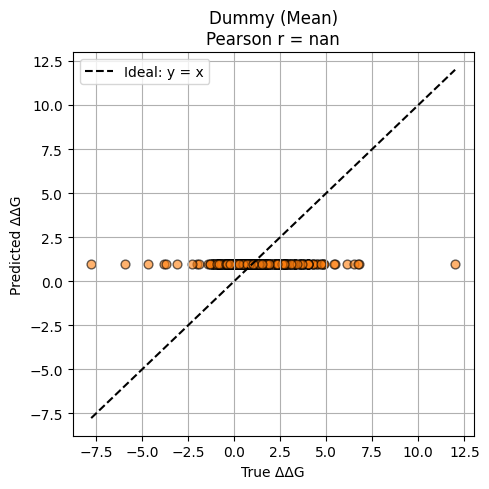

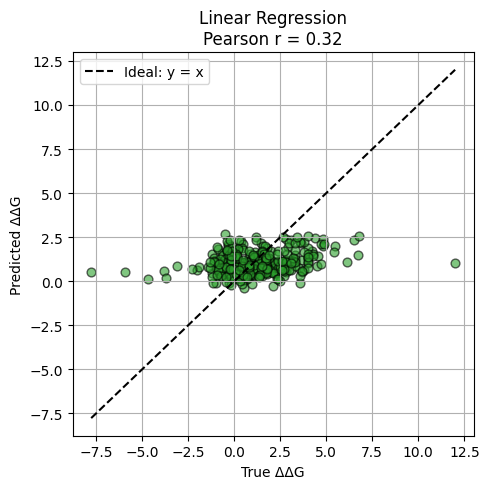

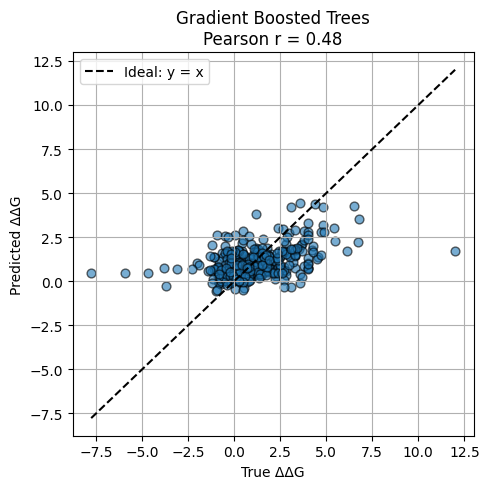

In [22]:
plot_model_scatter_individual_with_pearson(y_test, {
    "Dummy (Mean)": y_dum,
    "Linear Regression": y_lr,
    "Gradient Boosted Trees": y_gbr
})
